# توجه 

1. به راهنمایی هایی که در کد آمده است توجه کنید
2. مواردی که به صورت "#TODO"
را باید بصورتی که در صورت پروژه تعریف شده است انجام دهید. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install hazm
! pip install gensim==4.1.2
!pip install words
!pip install elasticsearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
from tqdm import tqdm
from gensim.models import Word2Vec
import numpy as np
import random
import pandas as pd
# import whatever you need for your implementation  

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# step 1 
داده هایی که در اختیار دارید را بارگذاری کنید و مشابه بخش های قبل پیش پردازش های لازم را انجام دهید. 
مطابق فازهای و بخش های پیشین پروژه مراحل پیش پردازش را انجام دهید. در نهایت لیست از اسناد بسازید که برای هر متن شامل توکن های آن متن باشد. 
این لیست میتواند ساختاری مطابق تصویر زیر داشته باشد.
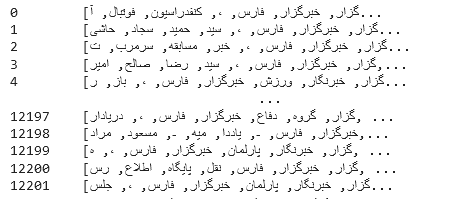

In [4]:
data_to_train_doc_to_vec = pd.read_excel("/content/drive/MyDrive/IR01_3_46k.xlsx")

In [5]:
from __future__ import unicode_literals
from hazm import *

In [6]:
my_normalizer=Normalizer()
dataset_for_doc_to_vec=[]

for i in range(len(data_to_train_doc_to_vec)):
  content_array=word_tokenize(my_normalizer.normalize(data_to_train_doc_to_vec.content[i]))
  dataset_for_doc_to_vec.append(content_array)


# گام دوم 
در این گام شما باید بتوانید که هر سند را به یک بردار عددی تبدیل کنید. این کار را به کمک ماژول آماده ایی که در اختیار شما قرار گرفته است انجام می شود.
بدین منظور مراحل زیر را انجام دهید. 










دو بلوک بعدی کد برای استفاده از ماژول آماده تهیه شده و صرفا به شکل مثال نوشته شده اند، ممکن است برای استفاده عملی در پروژه نیاز به تغییر باشد. 

In [7]:
from typing import List
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pathlib import Path



class DocToVec:
    
    def __init__(self, dataset:List[List] , vec_size = 200 , model_path = 'word2vec.model'):
        """ Here we train our model and calculate tf-idf weights.

        Args:
            dataset (List[List]): Each item of this list is a list of tokens obtained from a document.
            vec_size (int, optional): The size of the vector of each document. Defaults to 200.
            model_path (str, optional): The path of pre-trained model. If there is no file in the specified 
            path, It trains a model with the dataset and saves the trained model. Defaults to 'word2vec.model'.
        """

        self.vec_size = vec_size
        
        
        
        if not Path(model_path).is_file():
            print('There is no pre-trained model. Going to train a model ...')
            self.wordToVecModel = Word2Vec(
                window = 10,
                min_count=2,
                workers=4,
                vector_size = self.vec_size
            )
        
            self.wordToVecModel.build_vocab(dataset)
            
            self.wordToVecModel.train(
                dataset,
                total_examples = self.wordToVecModel.corpus_count,
                epochs = 20,
            )
            
            self.wordToVecModel.save(model_path)
            
        else:
            
            print('Loading the model ...')
            self.wordToVecModel = Word2Vec.load(model_path)
        
        con_train_data = [" ".join(a) for a in dataset]
        
        self.tfIdfVectorizer=TfidfVectorizer(use_idf=True,
                                        dtype = np.float64,
                                        lowercase = False,
                                        vocabulary = self.wordToVecModel.wv.index_to_key)
        
        self.tfIdfVectorizer.fit(con_train_data)
        
        dictionary = self.tfIdfVectorizer.get_feature_names()
        self.dictToNum = {d:i for i,d in enumerate(dictionary)}
        
        
    def embed(self, tokens:List):
        """Maps the input to a vector

        Args:
            tokens (List): List of tokens (don't forget to do preprocessing before 
            extracting tokens)

        Returns:
            Numpy Array: The vector of document
        """
        
        ti = self.tfIdfVectorizer.transform([" ".join(tokens)])
        
        weights = np.squeeze(np.asarray(ti[0].T.todense()))
        
        vec = np.zeros((self.vec_size,))
        sum_weights = 0
        for k in set(tokens):
            try:
                word_vec = self.wordToVecModel.wv[k]
                weight = weights[self.dictToNum[k]]
                vec += word_vec * weight
                sum_weights += weight
            except KeyError:
                pass
        vec /= sum_weights
        return vec
        


In [8]:
#from embedding import * 
# dataset: each document is a list of its tokens. 
# model_path: is a path that you want save model in it. 
doc2vec = DocToVec (dataset_for_doc_to_vec , vec_size = 200 , model_path = 'word2vec2.model')


Loading the model ...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



تولید بردارهای تمام اسناد و ذخیره در یک لیست بمنظور استفاده در گام های بعدی 

In [ ]:
%%time
doc_vectors = []
for i in tqdm(range(len(docs_list))):
  doc_vectors.append(doc2vec.embed(dataset[i])) 

# ابتدا بردارهای عددی داده های تست را بدست آورده و سپس از این بردارها برای تولید بردار  بقیه ی داده ها استفاده کنید. 

In [9]:
mapping = { 
    "mappings": {
        "properties": {
          "content": {
            "type": "text"
          },
            "category":{
                "type": "keyword"
            },
            "vec":{
                "type": "dense_vector",
                "dims": 200,
                "index": True,
                "similarity": "cosine"
            }
        }
    }
}

In [10]:
es = Elasticsearch(
    cloud_id="IR:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvOjQ0MyQ2NTdiMmI1MzE3YTc0OWNjYWQ0YTU1ZDM4ZGUyOGI0NiQzYTU2YWFlYzQ1NzI0YjkxOTZlN2YwOWExNDU3ODk2MQ==",
    basic_auth=("elastic", "TOseKiFNqilMmEBgf1i0Dv92")
    )

In [11]:
index_name = 'ir_knn'

In [12]:
# Delete index if one does exist
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# Create index
es.indices.create(index=index_name, body=mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ir_knn'})

In [13]:
data = pd.read_excel("/content/drive/MyDrive/IR01_3_test_4k.xlsx")

In [33]:
cult=set()
for i in range(len(data)):
  if i!=15:
    cult.add(data["category"][i])
cult

{'culture', 'economy', 'health', 'political', 'sport'}

In [14]:
from copy import deepcopy
data_tmp = []
for i in tqdm(range(len(data))):
    if i==15:
      continue
    tmp_doc = data
    doc = dict()
    # filter_doc: method for preprocessing a doc. 
    doc['content'] =tmp_doc['content'][i]
    doc['vec'] = list(doc2vec.embed(word_tokenize(my_normalizer.normalize(tmp_doc['content'][i]))))
    doc['category'] = tmp_doc['category'][i]
    data_tmp.append(doc)


100%|██████████| 4022/4022 [00:29<00:00, 137.89it/s]


In [15]:
data_bulk = [
    {
        "_index" : index_name,
        "_id" : i + 1,
        "_source": data_tmp[i]
    }
    for i in range(len(data_tmp))
]
resp = helpers.bulk(
  es,
  data_bulk,
  index = index_name
)
print(resp)

(4021, [])


# گام سوم

در این بخش باید داده های تست را بارگذاری و پیش پردازش کنید و سپس برای هر متن بردار آن را بدست آورده و به روش  نزدیکترین همسایه جستجو را انجام داده و برچسب این سند را بدست آورید. 

In [16]:
test_dataset = pd.read_excel("/content/drive/MyDrive/IR01_3_46k.xlsx")

In [17]:
test_dataset["content"][0]

'به گزارش ایسنا، پس از واریز ۴٧۵ هزار یورو از اصل طلب ماریو بودیمیر، این باشگاه\nباید ٣٢ هزار ۵٠٠ یورو دیگر را بابت سود دیرکرد به حساب این بازیکن واریز می\u200cکرد.\n\nاین مبلغ امروز به حساب بودیمیر رسید تا عملا موضوع پرونده این بازیکن کروات هم\nبسته و پنجره نقل\u200cوانتقالاتی پرسپولیس باز شود.\n\nانتهای پیام\n\n'

In [18]:
index_convertor={0:'culture', 1:'economy', 2:'health', 3:'political', 4:'sport'}
category_convertor={'culture':0, 'economy':1, 'health':2, 'political':3, 'sport':4}

In [19]:
import numpy as np
def find_label(array):
  ans=[0,0,0,0,0]
  for ar in array:
    ans[category_convertor[ar]]+=1
  #print(ans)
  return index_convertor[np.argmax(ans)]


In [20]:
res = []
for i in tqdm(range(len(test_dataset))):
    vec = doc2vec.embed(word_tokenize(my_normalizer.normalize(test_dataset['content'][i])))    
    try:
        resp = es.knn_search(index=index_name,knn={
          #  TODO
          "field":"vec",
          "query_vector":vec,
          "k":11,
          "num_candidates":100
          }
          ,source=['content','category'],)
        #print(resp["hits"]["hits"])

        cats=[]
        for uuu in resp["hits"]["hits"]:
          cats.append(uuu["_source"]["category"])
        res.append(find_label(cats))

      #  predict label for doc

      # TODO
    except:
        # usualy happens when all the elements of 
        # the vector are zero.
        res.append("None")
        pass
len(res)

100%|██████████| 46769/46769 [39:59<00:00, 19.49it/s]


46769

In [23]:
test_dataset["category"]=res
test_dataset.to_csv("/content/drive/MyDrive/answeranswer2.csv",index=False)

In [24]:
len(test_dataset)

46769

In [25]:
test_downloaded_csv=pd.read_csv("/content/drive/MyDrive/answeranswer.csv")

In [37]:
len(test_downloaded_csv)

46769

# گام چهارم 

حال که برای هر متن برچسب آن را بدست آورده اید. متون هر دسته را به نحوی از سایر دسته ها مجزا کنید و مطابق موارد خواسته شده در گزارش جستجو را در دسته های مختلف انجام دهید. 

In [32]:
index_final_0="culture"
index_final_1="economy"
index_final_2="health"
index_final_3="political"
index_final_4="sport"

In [33]:
# Create index
es.indices.create(index=index_final_0)
es.indices.create(index=index_final_1)
es.indices.create(index=index_final_2)
es.indices.create(index=index_final_3)
es.indices.create(index=index_final_4)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'sport'})

In [46]:
def fill_index(index_name_name,caty):
  data_tmp_tmp = []
  for i in tqdm(range(len(test_downloaded_csv))):
      tmp_doc = test_downloaded_csv
      if tmp_doc["category"][i]!=caty:
        continue
      doc = dict()
      doc['content'] =tmp_doc['content'][i]
      doc['url']=tmp_doc['url'][i]
      data_tmp_tmp.append(doc)
  data_bulk = [
      {
          "_index" : index_name_name,
          "_id" : i + 1,
          "_source": data_tmp_tmp[i]
      }
      for i in range(len(data_tmp_tmp))
  ]
  resp = helpers.bulk(
    es,
    data_bulk,
    index = index_name_name
  )
  print(resp)

In [47]:
fill_index(index_final_0,"culture")
fill_index(index_final_1,"economy")
fill_index(index_final_2,"health")
fill_index(index_final_3,"political")
fill_index(index_final_4,"sport")

100%|██████████| 46769/46769 [00:00<00:00, 111849.99it/s]


(9422, [])


100%|██████████| 46769/46769 [00:00<00:00, 103770.61it/s]


(12963, [])


100%|██████████| 46769/46769 [00:00<00:00, 142058.04it/s]


(1916, [])


100%|██████████| 46769/46769 [00:00<00:00, 110082.08it/s]


(11453, [])


100%|██████████| 46769/46769 [00:00<00:00, 108703.74it/s]


(11014, [])


In [41]:
def get_query(text):
    body ={
    "query":{  
        "match" : {
            "content" : text

            }
        }
    }
    
    return body

In [65]:
def show_results_for(text,caty):
  choosen_index=""
  if caty=="culture":
    choosen_index=index_final_0
  elif caty=="economy":
    choosen_index=index_final_1
  elif caty=="health":
    choosen_index=index_final_2
  elif caty=="political":
    choosen_index=index_final_3
  elif caty=="sport":
    choosen_index=index_final_4
  rslt=es.search(index=choosen_index, body=get_query(text))
  i=0
  for t in rslt["hits"]["hits"]:
    if i>=5:
      break
    print(t["_source"]["url"])
    i+=1


In [72]:
show_results_for("رونالدو مسی توپ طلا","sport")

https://www.farsnews.ir/news/13991117000185/مقایسه-آمار-نیمار-با-مسی-و-رونالدو-عکس
https://www.farsnews.ir/news/14000105000155/یک-قدم-تا-تاریخ-سازی-مودریچ-برای-فوتبال-کرواسی
https://www.farsnews.ir/news/13991204000939/بازیکنانی-با-بیشترین-جام-در-قرن-2-شش-بازیکن-بالاتر-از-رونالدو
https://www.farsnews.ir/news/14000123000541/اقدام-جنجالی-رونالدو-ابرستاره-پرتغالی-در-راه-جدایی-از-یوونتوس
https://www.farsnews.ir/news/13991222000112/احتمال-بازگشت-رونالدو-به-رئال-مادرید


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  del sys.path[0]


In [79]:
show_results_for("عربستان آمریکا","economy")

https://www.farsnews.ir/news/13990614000393/کاهش-صادرات-نفت-عربستان-به-آمریکا-به-کمترین-میزان-در-سه-دهه-گذشته
https://www.farsnews.ir/news/13991021000701/صادرات-نفت-عربستان-به-آمریکا-برای-نخستین-بار-در-35-سال-گذشته-صفر-شد
https://www.farsnews.ir/news/13990330000392/صادرات-نفت-عربستان-به-آمریکا-به-کمترین-میزان-در-35-سال-گذشته-می‌رسد
https://www.farsnews.ir/news/13990915000599/صادرات-نفت-عربستان-به-آمریکا-به-کمترین-رقم-در-35-سال-گذشته-رسید
https://www.farsnews.ir/news/14000120000166/گرفتاری-دهلی-نو-در-تبعیت-از-تحریم‌های-نفتی-ایران-پکن-برنده-ادامه-خرید


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  del sys.path[0]


In [80]:
show_results_for("کرونا واکسن قرنطینه","health")

https://www.farsnews.ir/news/14000111000564/روحانی-اقدامات-فوری-برای-جلوگیری-از-موج-جدید-بیماری-انجام-شود
https://www.farsnews.ir/news/13991111001085/سفرهای-نوروزی-در-قالب-تورها-انجام-می‌گیرد-وضعیت-دست-فروش‌ها-بررسی-شد
https://www.farsnews.ir/news/14000131000237/ربیعی-برجام-باعث-تقویت-اعتماد-به-نفس-ملی-شد-بخشی-از-پولی-که-در-عراق
https://www.isna.ir/news/99122519197/واکسیناسیون-سالمندان-علیه-کرونا-در-کردستان-آغاز-شد
https://www.isna.ir/news/99121309975/اقدامات-فوری-برای-خرید-واکسن-کرونا-صورت-گیرد


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  del sys.path[0]
